In [110]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree   import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# for class imbalance
from imblearn.over_sampling import SMOTE
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)


In [111]:
data_dir = os.path.join(os.getcwd(),"..","Data","WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(data_dir)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [112]:
df.shape

(7043, 21)

In [113]:
df.info(

)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [114]:
df = df.drop_duplicates()
df = df.drop(columns=['customerID'])
# we don't need customer ID for modelling


In [115]:

for col in df.columns:
    print(col,df[col].unique(),sep = ":-")

gender:-['Female' 'Male']
SeniorCitizen:-[0 1]
Partner:-['Yes' 'No']
Dependents:-['No' 'Yes']
tenure:-[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService:-['No' 'Yes']
MultipleLines:-['No phone service' 'No' 'Yes']
InternetService:-['DSL' 'Fiber optic' 'No']
OnlineSecurity:-['No' 'Yes' 'No internet service']
OnlineBackup:-['Yes' 'No' 'No internet service']
DeviceProtection:-['No' 'Yes' 'No internet service']
TechSupport:-['No' 'Yes' 'No internet service']
StreamingTV:-['No' 'Yes' 'No internet service']
StreamingMovies:-['No' 'Yes' 'No internet service']
Contract:-['Month-to-month' 'One year' 'Two year']
PaperlessBilling:-['Yes' 'No']
PaymentMethod:-['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges:-[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalChar

In [116]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges']*df['tenure'])  # Fill NaN with MonthlyCharges

binary_mapper = {"Yes": 1, "No": 0}



for col in [ 'Churn']:
    df[col] = df[col].map(binary_mapper)

df.dtypes

# senior citizen to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')


In [117]:
df.Churn.value_counts()
# class imbalance

Churn
0    5174
1    1869
Name: count, dtype: int64

In [118]:
# tenure * monthly charges = total charges

## EDA

In [119]:
df.describe(include = "number")

,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,0.265370
std,24.559481,30.090047,2266.794470,0.441561
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,398.550000,0.000000
50%,29.000000,70.350000,1394.550000,0.000000
75%,55.000000,89.850000,3786.600000,1.000000
max,72.000000,118.750000,8684.800000,1.000000


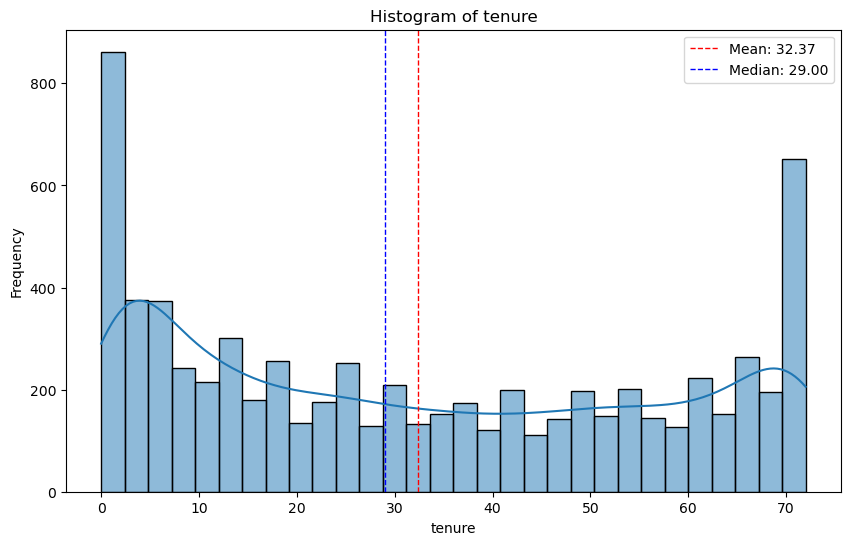

In [120]:
def plot_histogram(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # calculate the mean and median
    mean = df[column].mean()
    median = df[column].median()
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    plt.legend()
    plt.show()

plot_histogram(df, 'tenure')

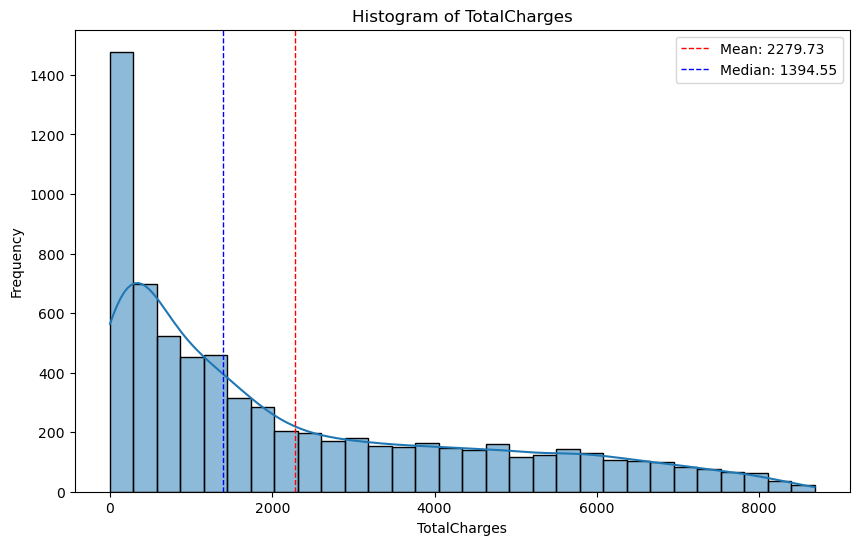

In [121]:
plot_histogram(df, 'TotalCharges')

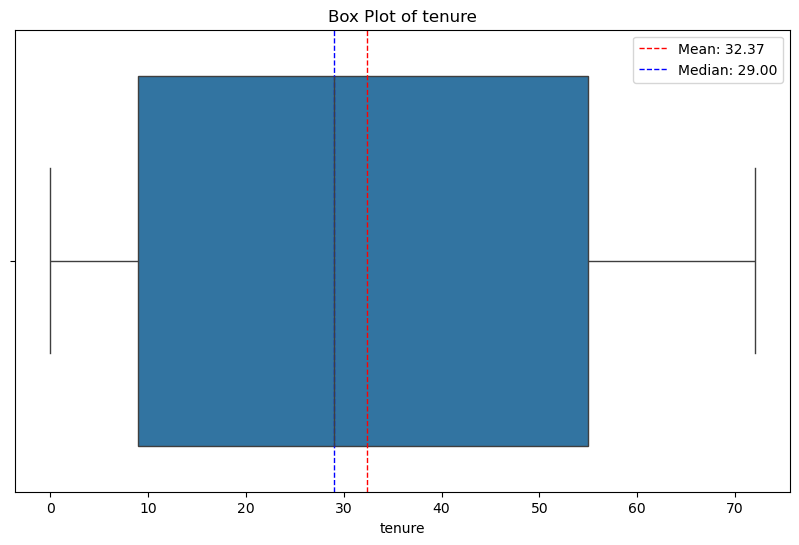

In [122]:
def plot_boxplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    col_mean = df[column].mean()
    col_median = df[column].median()
    plt.axvline(col_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {col_mean:.2f}')
    plt.axvline(col_median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {col_median:.2f}')
    plt.legend()
    plt.xlabel(column)
    plt.show()

plot_boxplot(df, 'tenure')

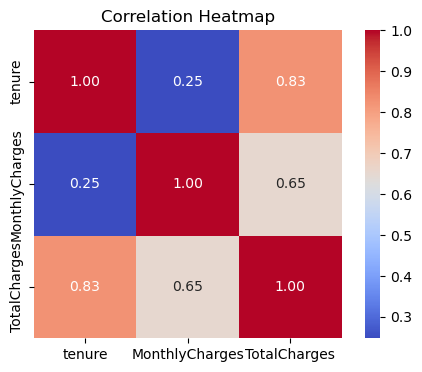

In [123]:
def plot_correlation_heatmap(df,colList = []):
    plt.figure(figsize=(6, 4))
    corr = df[colList].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(df, ['tenure', 'MonthlyCharges', 'TotalCharges'])

# tenure and MonthlyCharges are correlated with TotalCharges

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


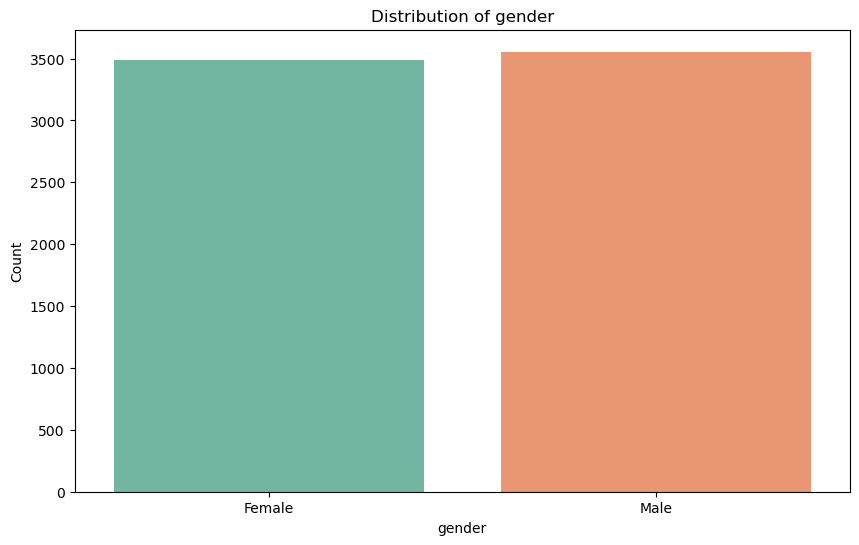

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


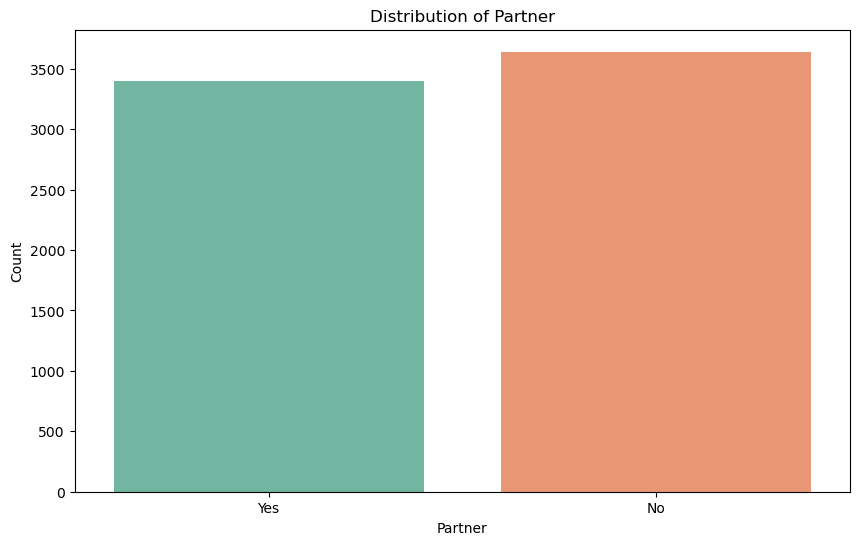

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


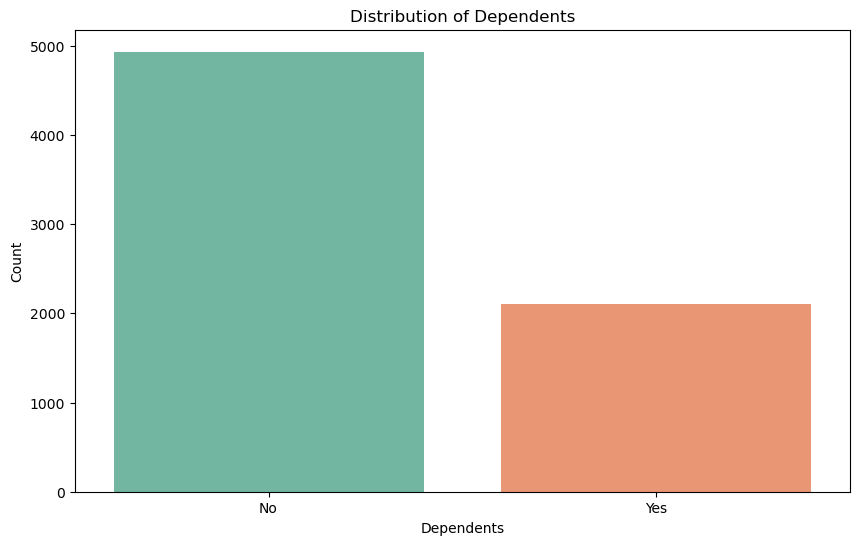

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


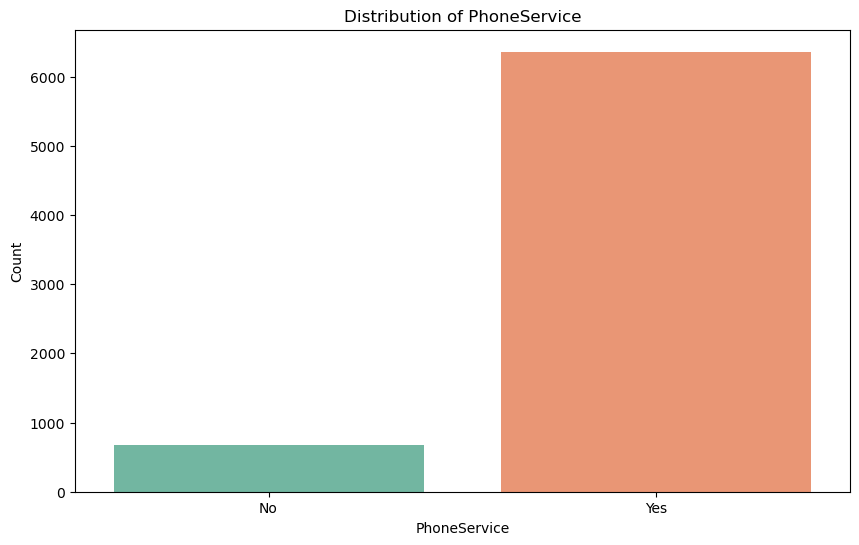

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


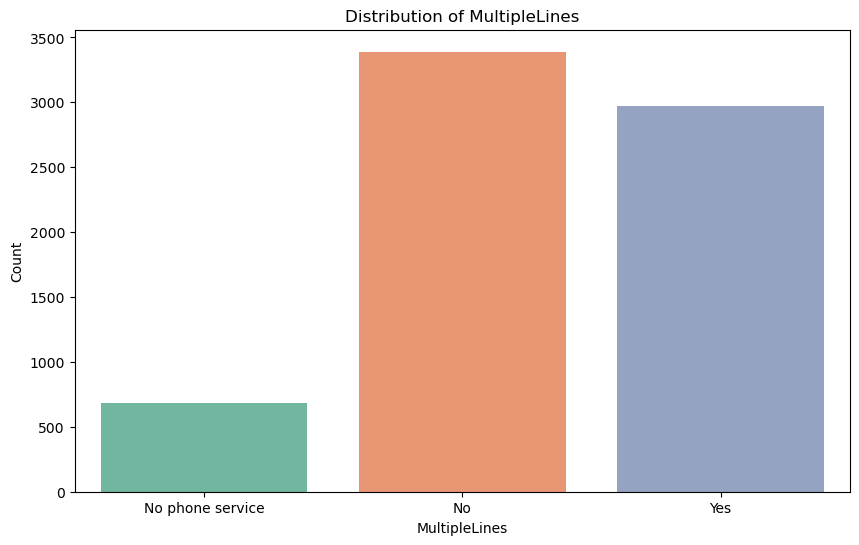

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


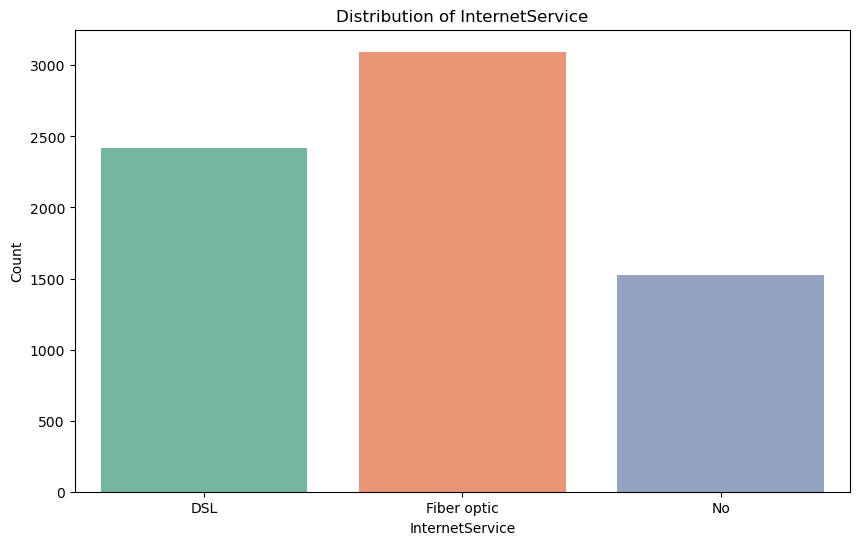

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


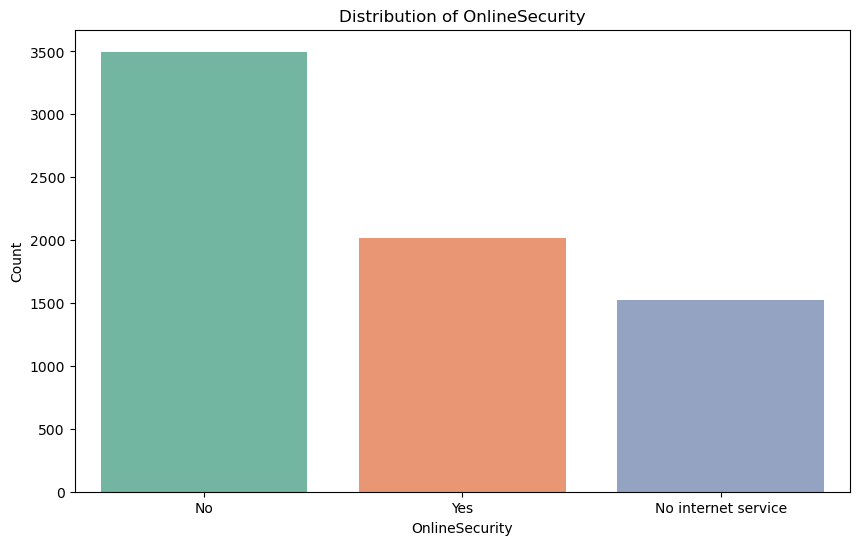

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


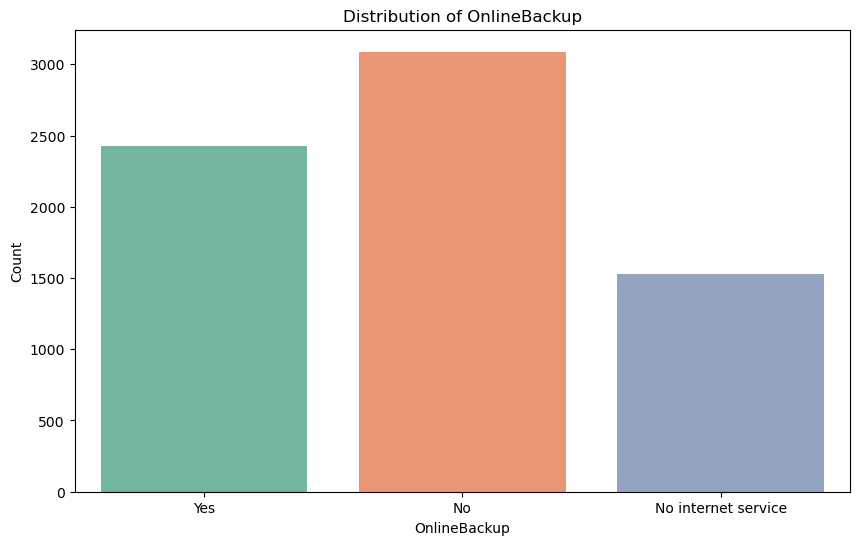

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


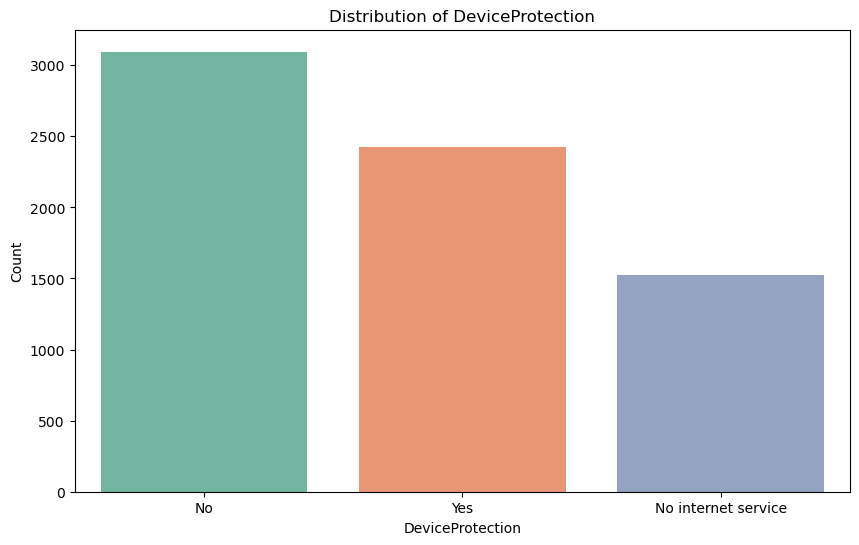

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


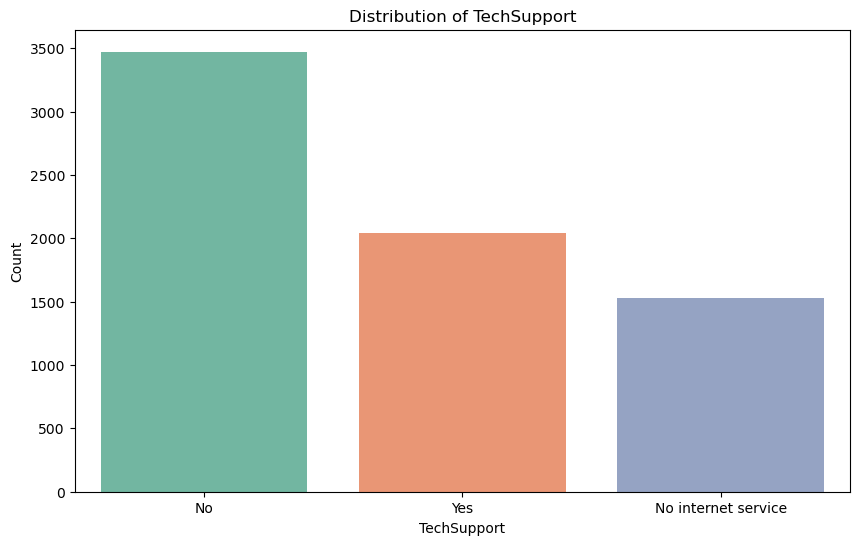

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


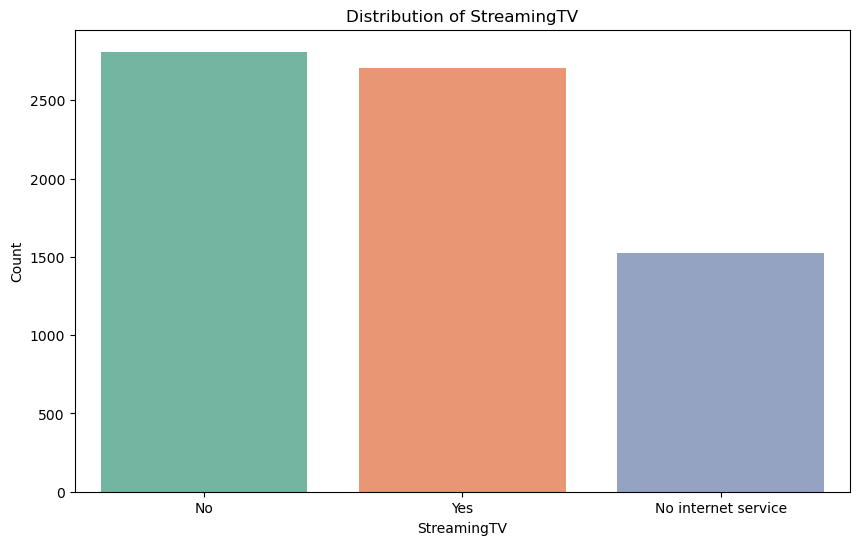

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


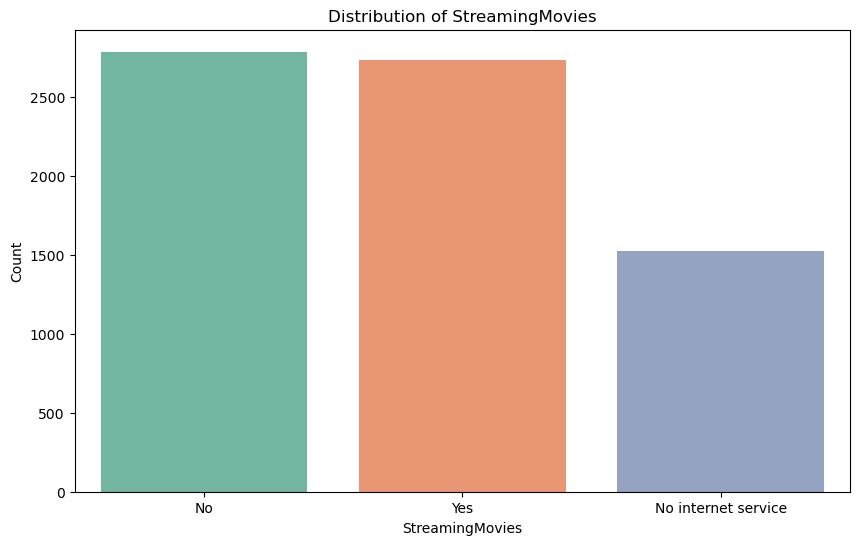

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


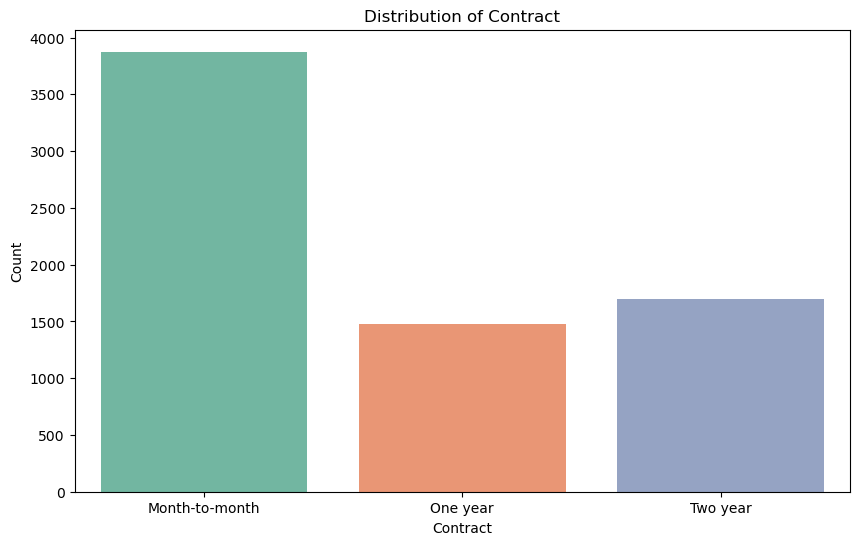

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


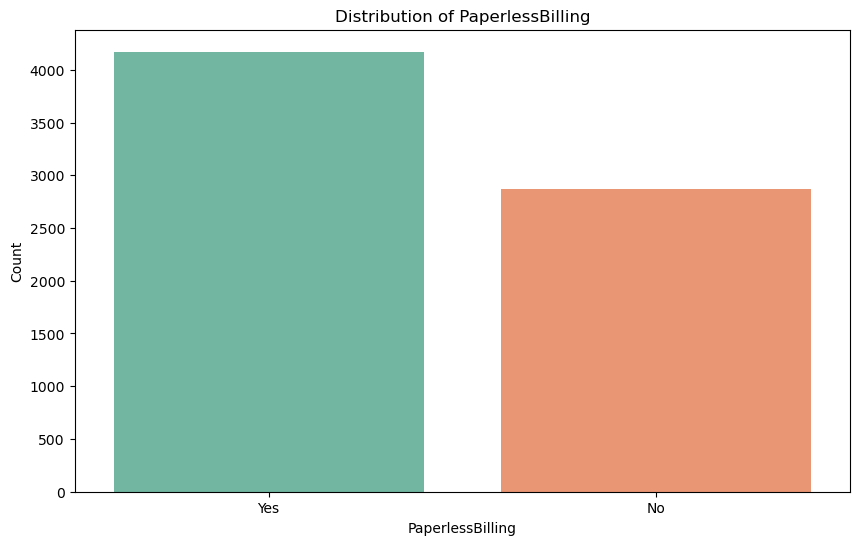

/var/folders/vd/729qptzn30x2hvptqg5739dr0000gn/T/ipykernel_2124/906801398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


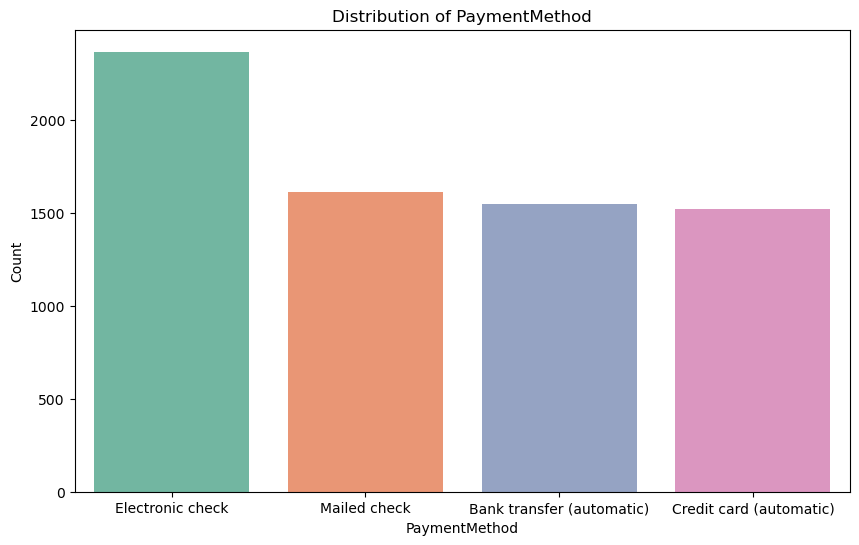

In [124]:
# List all the categorical columns (after encoding, so only true object columns remain)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
#cat_cols.append([ 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'])

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, palette='Set2')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Plot for each categorical column
for col in cat_cols:
    plot_categorical_distribution(df, col)

In [125]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [127]:
encoders = dict()
# cat_cols.remove("Churn")
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

pickle.dump(encoders, open(os.path.join(os.getcwd(),"..","Data","encoders.pkl"), "wb"))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


### Train test split

In [128]:
data = df.loc[:, df.columns != 'Churn']
target = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
# what does straitify do?

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 19), (1409, 19), (5634,), (1409,))

In [129]:
y_train.value_counts(), y_test.value_counts()

(Churn
 0    4138
 1    1496
 Name: count, dtype: int64,
 Churn
 0    1036
 1     373
 Name: count, dtype: int64)

In [131]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

Churn
0    4138
1    4138
Name: count, dtype: int64

In [139]:
models = {
    
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    }

cv_scores = {}
# perform 5 fold cross-validation for each model
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    cv_scores[model_name] = scores
    print(f"{model_name} - Cross-Validation Scores: {scores}")
    print(f"{model_name} - Mean CV Score: {np.mean(scores):.4f}")

Decision Tree - Cross-Validation Scores: [0.6884058  0.72205438 0.84712991 0.84531722 0.85196375]
Decision Tree - Mean CV Score: 0.7910
Random Forest - Cross-Validation Scores: [0.72403382 0.75770393 0.9081571  0.90392749 0.90876133]
Random Forest - Mean CV Score: 0.8405


In [140]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)
y_pred = rfc.predict(X_test)
print("Random Forest Classifier - Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Classifier - Accuracy on Test Set: 0.7785663591199432
Confusion Matrix:
 [[886 150]
 [162 211]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1036
           1       0.58      0.57      0.57       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

